# Comparing GNNs and baseline performances
---

**Libraries**

In [1]:
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objs as go


In [39]:
def load_dict(path: str, filename: str) -> dict:
    """Load dictionary."""
    with open(f'{os.path.join(path, filename)}', 'rb') as f:
        data = pickle.load(f)
    return data

def data2df(path: str, **kwargs):
    """Load data and save it to DataFrame."""
    # Initialize DataFrame
    df = pd.DataFrame(columns=['dataset', 'model', 'k', 'train_acc', 'test_acc', 'computation_time'])
    n_params = len(kwargs.keys())

    # Load data
    for i, file in enumerate(os.listdir(path)):
        cpt = 0
        for key_elem, value in kwargs.items():
            if (str(key_elem) + str(value).lower()) not in file:
                cpt += 1
        
        if cpt == 0:
            # Load data
            data = load_dict(path, file)
            k = data.get('meta').k
            try:
                if data.get('meta').embedding_method is not None:
                    model = data.get('meta').model + '_embedding_method' + data.get('meta').embedding_method
                else:
                    model = data.get('meta').model
            except:
                model = data.get('meta').model
            mydf = pd.DataFrame({'dataset': [data.get('meta').dataset] * k,
                        'model': [model] * k,
                        'k': [k] * k,
                        'train_size': [1 - (2 * (1 / k))] * k,
                        'test_size': [2 * (1 / k)] * k, # test + val
                        'train_acc': data.get('results').get('train acc'),
                        'test_acc': data.get('results').get('test acc'),
                        'computation_time': data.get('results').get('elapsed_time')})
            df = pd.concat([df, mydf.sort_values('test_size')], ignore_index=True)
        
    return df

# From StackOverflow
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands."""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

## Load data

In [41]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
#df = data2df(RUNPATH, undir=True, penalized=True)
df = data2df(RUNPATH, undirected=True, penalized=True)
df

cora_undirectedtrue_penalizedtrue_randomstate8_k10_stratifiedtrue_knn_embedding_methodtrue
cora_undirectedtrue_penalizedtrue_randomstate8_k10_stratifiedtrue_knn


,dataset,model,k,train_acc,test_acc,train_size,test_size
0,cora,KNN_embedding_methodtrue,10,1.0,0.731362,0.8,0.2
1,cora,KNN_embedding_methodtrue,10,1.0,0.765683,0.8,0.2
2,cora,KNN_embedding_methodtrue,10,1.0,0.760763,0.8,0.2
3,cora,KNN_embedding_methodtrue,10,1.0,0.710332,0.8,0.2
4,cora,KNN_embedding_methodtrue,10,1.0,0.719557,0.8,0.2
5,cora,KNN_embedding_methodtrue,10,1.0,0.748462,0.8,0.2
6,cora,KNN_embedding_methodtrue,10,1.0,0.769988,0.8,0.2
7,cora,KNN_embedding_methodtrue,10,1.0,0.790283,0.8,0.2
8,cora,KNN_embedding_methodtrue,10,1.0,0.786198,0.8,0.2
9,cora,KNN_embedding_methodtrue,10,1.0,0.745062,0.8,0.2


In [16]:
df[df['model'].str.startswith('KNN')]

,dataset,model,k,train_acc,test_acc,train_size,test_size
87,cora,KNN,4,1.0,0.748892,0.500000,0.500000
88,cora,KNN,4,1.0,0.717134,0.500000,0.500000
89,cora,KNN,4,1.0,0.700886,0.500000,0.500000
90,cora,KNN,4,1.0,0.771787,0.500000,0.500000
101,pubmed,KNN,10,1.0,0.798123,0.800000,0.200000
...,...,...,...,...,...,...,...
1912,cora,KNN,11,1.0,0.788618,0.818182,0.181818
1913,cora,KNN,11,1.0,0.780488,0.818182,0.181818
1914,cora,KNN,11,1.0,0.786585,0.818182,0.181818
1915,cora,KNN,11,1.0,0.792683,0.818182,0.181818


Compute **average** and **standard deviation** on $k$-folds for each run.

In [4]:
# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

,dataset,model,k,train_size,test_size,train_acc_avg,train_acc_std,test_acc_avg,test_acc_std
0,citeseer,Diffusion,3,0.333333,0.666667,1.000000,0.000000,0.623986,0.011954
1,citeseer,Diffusion,4,0.500000,0.500000,1.000000,0.000000,0.665916,0.009446
2,citeseer,Diffusion,5,0.600000,0.400000,1.000000,0.000000,0.676580,0.016067
3,citeseer,Diffusion,6,0.666667,0.333333,1.000000,0.000000,0.689207,0.014308
4,citeseer,Diffusion,7,0.714286,0.285714,1.000000,0.000000,0.691157,0.015474
...,...,...,...,...,...,...,...,...,...
234,pubmed,SGC,6,0.666667,0.333333,0.654494,0.001059,0.654030,0.003400
235,pubmed,SGC,7,0.714286,0.285714,0.654498,0.000643,0.654165,0.005878
236,pubmed,SGC,8,0.750000,0.250000,0.654602,0.000896,0.654030,0.005815
237,pubmed,SGC,9,0.777778,0.222222,0.654736,0.001041,0.654292,0.005435


## Plot results

Display performances on `training` and `test` splits for each model and baseline, for each value of $k$.

In [6]:
# training split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped,
        x = 'train_size',
        y = 'train_acc_avg',
        error_y = 'train_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Training accuracy',
        markers = '.',
    )
    fig.show()

Training performances of all baseline models (except `PageRank`) is 1, since the seeds label are know by the model.  
For GNN-based model on the contrary, training performances increase as the proportion of test nodes 

In [7]:
# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='cora'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

### Citeseer

In [8]:
# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='citeseer'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

### PubMed

In [9]:
# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='pubmed'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

## Without penalization

In [12]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undir=True, penalized=False)
print(df.shape)

# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped,
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

(450, 7)


## Directed graph + not penalized

In [13]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undir=False, penalized=False)
print(df.shape)

# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped,
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

(450, 7)


## Directed + penalized

In [14]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undir=False, penalized=True)
print(df.shape)

# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped,
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

(450, 7)


## Wikivitals datasets
---

In [3]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undirected=False, penalized=True)
print(df.shape)

(884, 7)


In [8]:
df.dataset.unique(), df.model.unique()

(array(['wikivitals-fr', 'wikivitals', 'wikischools'], dtype=object),
 array(['KNN_embedding_methodtrue', 'LabelPropagation', 'GAT', 'KNN',
        'Diffusion', 'PageRank', 'GCN'], dtype=object))

### `Wikivitals`

In [10]:
# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='wikivitals'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

### `Wikivitals-fr`

In [11]:
# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='wikivitals-fr'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

### `Wikischools`

In [12]:
# Compute average and standard deviation according to values of k
grouped = df.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='wikischools'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

## Wikivitals datasets using features

In [85]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undirected=False, penalized=True, use_features=True)
df_gnns = data2df(RUNPATH, undirected=False, penalized=True)
df_gnns = df_gnns[(df_gnns['model'] == 'GCN') | (df_gnns['model'] == 'GAT') | (df_gnns['model'] == 'GraphSage') | (df_gnns['model'] == 'SGC')]

In [42]:
df.model.unique(), df_gnns.model.unique()

(array(['KNN', 'PageRank', 'KNN_embedding_methodtrue', 'Diffusion',
        'LabelPropagation'], dtype=object),
 array(['GAT', 'GCN'], dtype=object))

In [43]:
df_tot = pd.concat([df, df_gnns])

In [44]:
# Compute average and standard deviation according to values of k
grouped = df_tot.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='wikivitals'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

## Computation times x performance

## Planetoid datasets

### Using features

In [115]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undirected=True, penalized=True, use_features=True)
df_gnns = data2df(RUNPATH, undir=True, penalized=True)
df_gnns = df_gnns[(df_gnns['model'] == 'GCN') | (df_gnns['model'] == 'GAT') | (df_gnns['model'] == 'GraphSage') | (df_gnns['model'] == 'SGC')]
df_tot = pd.concat([df, df_gnns])

In [122]:
# Compute average and standard deviation according to values of k
grouped = df_tot.groupby(['dataset', 'model', 'k', 'train_size', 'test_size'])[['train_acc', 'test_acc']].agg({'train_acc': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'k', 'train_size', 'test_size', 'train_acc_avg', 'train_acc_std', 'test_acc_avg', 'test_acc_std', ]
grouped

# Test split
for error_y_mode in {'band'}:
    fig = line(
        data_frame = grouped[grouped['dataset']=='cora'],
        x = 'test_size',
        y = 'test_acc_avg',
        error_y = 'test_acc_std',
        error_y_mode = error_y_mode,
        color = 'model',
        title = f'Test accuracy',
        markers = '.',
    )
    fig.show()

In [117]:
df_filt_k9 = df_tot[df_tot['k']==9]

# Compute average and standard deviation according to values of k
grouped = df_filt_k9.groupby(['dataset', 'model'])[['computation_time', 'test_acc']].agg({'computation_time': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'computation_time_avg', 'computation_time_std', 'test_acc_avg', 'test_acc_std']

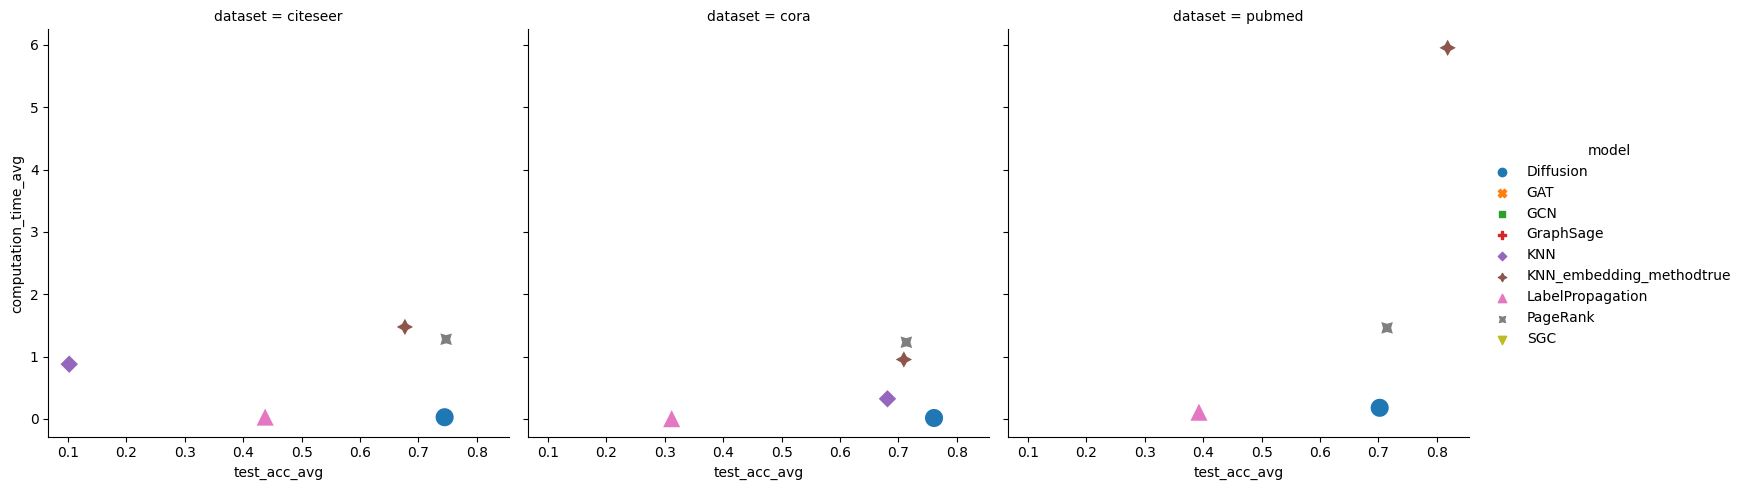

In [118]:
import seaborn as sns
sns.relplot(
    data=grouped, y="computation_time_avg", x="test_acc_avg",
    col="dataset", hue="model", style="model",
    kind="scatter", s=200
);

## Wikivitals datasets

### Using features

In [109]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undirected=False, penalized=True, use_features=True)
df_gnns = data2df(RUNPATH, undirected=False, penalized=True)
df_gnns = df_gnns[(df_gnns['model'] == 'GCN') | (df_gnns['model'] == 'GAT') | (df_gnns['model'] == 'GraphSage') | (df_gnns['model'] == 'SGC')]
df_tot = pd.concat([df, df_gnns])

In [101]:
df_filt_k9 = df_tot[df_tot['k']==9]

# Compute average and standard deviation according to values of k
grouped = df_filt_k9.groupby(['dataset', 'model'])[['computation_time', 'test_acc']].agg({'computation_time': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'computation_time_avg', 'computation_time_std', 'test_acc_avg', 'test_acc_std']

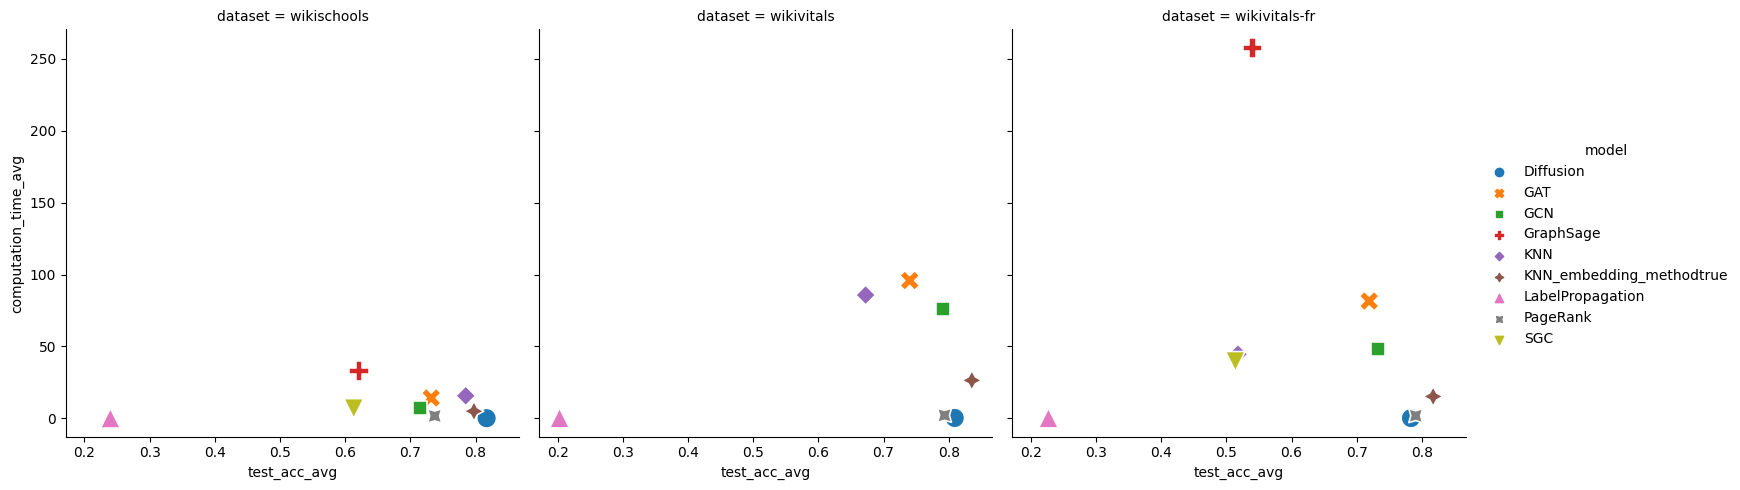

In [103]:
import seaborn as sns
sns.relplot(
    data=grouped, y="computation_time_avg", x="test_acc_avg",
    col="dataset", hue="model", style="model",
    kind="scatter", s=200
);

### Using graph structure

In [107]:
RUNPATH = os.path.join(os.path.dirname(os.getcwd()), 'runs')

# Store data into DataFrame
df = data2df(RUNPATH, undirected=False, penalized=True)
df_gnns = data2df(RUNPATH, undirected=False, penalized=True)
df_gnns = df_gnns[(df_gnns['model'] == 'GCN') | (df_gnns['model'] == 'GAT') | (df_gnns['model'] == 'GraphSage') | (df_gnns['model'] == 'SGC')]
df_tot = pd.concat([df, df_gnns])

df_filt_k9 = df_tot[df_tot['k']==9]

# Compute average and standard deviation according to values of k
grouped = df_filt_k9.groupby(['dataset', 'model'])[['computation_time', 'test_acc']].agg({'computation_time': ['mean', 'std'], 'test_acc': ['mean', 'std']}).reset_index()
grouped.columns = ['dataset', 'model', 'computation_time_avg', 'computation_time_std', 'test_acc_avg', 'test_acc_std']

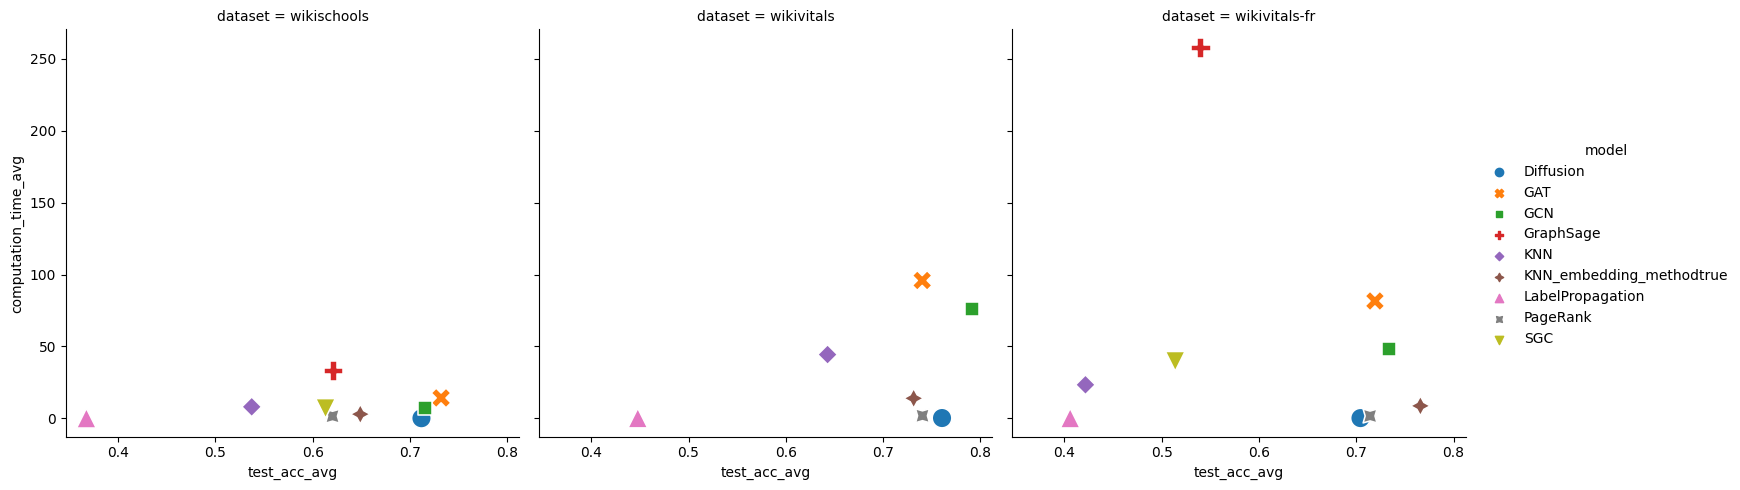

In [108]:
import seaborn as sns
sns.relplot(
    data=grouped, y="computation_time_avg", x="test_acc_avg",
    col="dataset", hue="model", style="model",
    kind="scatter", s=200
);